最初に、このノートブックを実行するために必要なモジュールとデータの読み込みを行います。

In [1]:
pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=9454bd1dc305a66586bbe8720735c9d801cc2e719bbe05c38c326f420a5ffafc
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import copy
import seaborn as sns
import japanize_matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import lightgbm as lgb
from PIL import Image
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.3f}'.format)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#pathは各自データの置いてある場所に変更してください
path = '/content/drive/MyDrive/Colab_Notebooks'
df = pd.read_csv(path + '/hotel_bookings.csv')


# 1.背景整理・EDA

今回扱うデータセットは、Hotel booking demandが提供したリスボンのシティホテルとアルガルヴェのリゾートホテル（いずれもポルトガル）の予約情報です。各行は個々の予約を表し、各列は予約に関するさまざまな情報を示しています。このnotebookでは特にEDAパートに注力して、市場分析は補助的に扱っていきます。

### 1-1.市場分析

データセットは2015-2017年のポルトガルにおける宿泊データですが、初めに日本の市場を仮定して市場規模や最近の動向について確認してみます。

- ホテル業界の市場規模  帝国データバンク[「旅館・ホテル業界」 動向調査（2022年度）](https://www.tdb.co.jp/report/watching/press/p230702.html)より
  - およそ3.4兆円。
  - 21年度と比較して18.8%増加している。


- 近年の宿泊者の傾向や問題点など  観光庁の[宿泊旅行統計調査　2023年](https://www.mlit.go.jp/kankocho/content/001732306.pdf)より

  - コロナ下であった2022年と比較して日本人・外国人ともに宿泊数が増加。
  - コロナ以前の2019年と比較すると宿泊者数は微減。
  - 客室稼働率の平均は57.4%。都道府県やホテルタイプで大きく差がある。


### 1-2.EDA(データプレパレーション)

以下はカラムの説明になります。
- hotel: ホテルの種類
- is_canceled: 予約がキャンセルされたかどうか
- lead_time: 予約が行われた日から宿泊日までの日数
- arrival_date_year: 到着日の年
- arrival_date_month: 到着日の月
- arrival_date_week_number: 到着日が何週目であるか
- arrival_date_day_of_month: 到着日の日付
- stays_in_weekend_nights: 宿泊に含まれる週末の日数
- stays_in_week_nights: 宿泊に含まれる平日の日数
- adults: 大人の数
- children: 子供の数
- babies: 赤ちゃんの数
- meal: 食事の種類
- country: どの国の顧客が予約したか
- market_segment: 旅行代理店やツアーといった予約の形式
- distribution_channel: 顧客がどこを通して予約したか
- is_repeated_guest: 予約者がリピーターかどうか
- previous_cancellations: 以前の予約のキャンセル回数
- previous_bookings_not_canceled: 以前の予約がキャンセルされていない回数
- reserved_room_type: 予約された部屋のタイプ
- assigned_room_type: 実際に宿泊した部屋のタイプ
- booking_changes: 予約の変更回数
- deposit_type: デポジットの種類
- agent: 予約を取り扱った代理店のID
- company: 予約を取り扱った会社のID
- days_in_waiting_list: キャンセル待ちとなっている日数
- customer_type: 顧客タイプ
- adr: 1泊あたりの平均支払い額
- required_car_parking_spaces:駐車スペースの数
- total_of_special_requests: 特別リクエストの合計数
- reservation_status: 予約ステータス
- reservation_status_date: 予約ステータスが更新された日付

ここでは簡単なEDAを行い、与えられたデータにどのようなカラムがあるか、欠損値やデータ型など、概要を把握していきます。

チェックの結果以下のようなことがわかります。
- データ数: 119390
- カラム数: 32
- 欠損値: 4つのカラム
- カテゴリカル変数: 12個
- 数値変数: 20個

In [56]:
print('データのデータ数は{}、変数は{}種類です。'.format(df.shape[0], df.shape[1]))

データのデータ数は119390、変数は32種類です。


In [57]:
pd.set_option('display.max_columns', 32)

df.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.000,0,BB,PRT,Direct,Direct,0,0,0,Other,Other,3,No Deposit,NaN,NaN,0,Transient,0.000,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.000,0,BB,PRT,Direct,Direct,0,0,0,Other,Other,4,No Deposit,NaN,NaN,0,Transient,0.000,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.000,0,BB,GBR,Direct,Direct,0,0,0,Business,Other,0,No Deposit,NaN,NaN,0,Transient,75.000,0,0,Check-Out,2015-07-02


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [59]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000,119390.000,119390.000,119390.000,119390.000,119390.000,119390.000,119390.000,119386.000,119390.000,119390.000,119390.000,119390.000,119390.000,103050.000,6797.000,119390.000,119390.000,119390.000,119390.000
mean,0.370,104.011,2016.157,27.165,15.798,0.928,2.500,1.856,0.104,0.008,0.032,0.087,0.137,0.221,86.693,189.267,2.321,101.831,0.063,0.571
std,0.483,106.863,0.707,13.605,8.781,0.999,1.908,0.579,0.399,0.097,0.176,0.844,1.497,0.652,110.775,131.655,17.595,50.536,0.245,0.793
min,0.000,0.000,2015.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,6.000,0.000,-6.380,0.000,0.000
25%,0.000,18.000,2016.000,16.000,8.000,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,9.000,62.000,0.000,69.290,0.000,0.000
50%,0.000,69.000,2016.000,28.000,16.000,1.000,2.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,14.000,179.000,0.000,94.575,0.000,0.000
75%,1.000,160.000,2017.000,38.000,23.000,2.000,3.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,229.000,270.000,0.000,126.000,0.000,1.000
max,1.000,737.000,2017.000,53.000,31.000,19.000,50.000,55.000,10.000,10.000,1.000,26.000,72.000,21.000,535.000,543.000,391.000,5400.000,8.000,5.000


In [60]:
null = pd.DataFrame({'Null Values' : df.isna().sum(), 'Percentage Null Values' : (df.isna().sum()) / (df.shape[0]) * (100)})
null[null['Null Values'] > 0]

,Null Values,Percentage Null Values
children,4,0.003
country,488,0.409
agent,16340,13.686
company,112593,94.307


次にカラムの内容の確認を行います

初めに数値型データのカウントプロット/ヒストグラムを見てみます。

ここからキャンセル率がやや高そうなこと、子供や赤ちゃんの数が少ないこと、リピーターが少ないことなどがわかります。

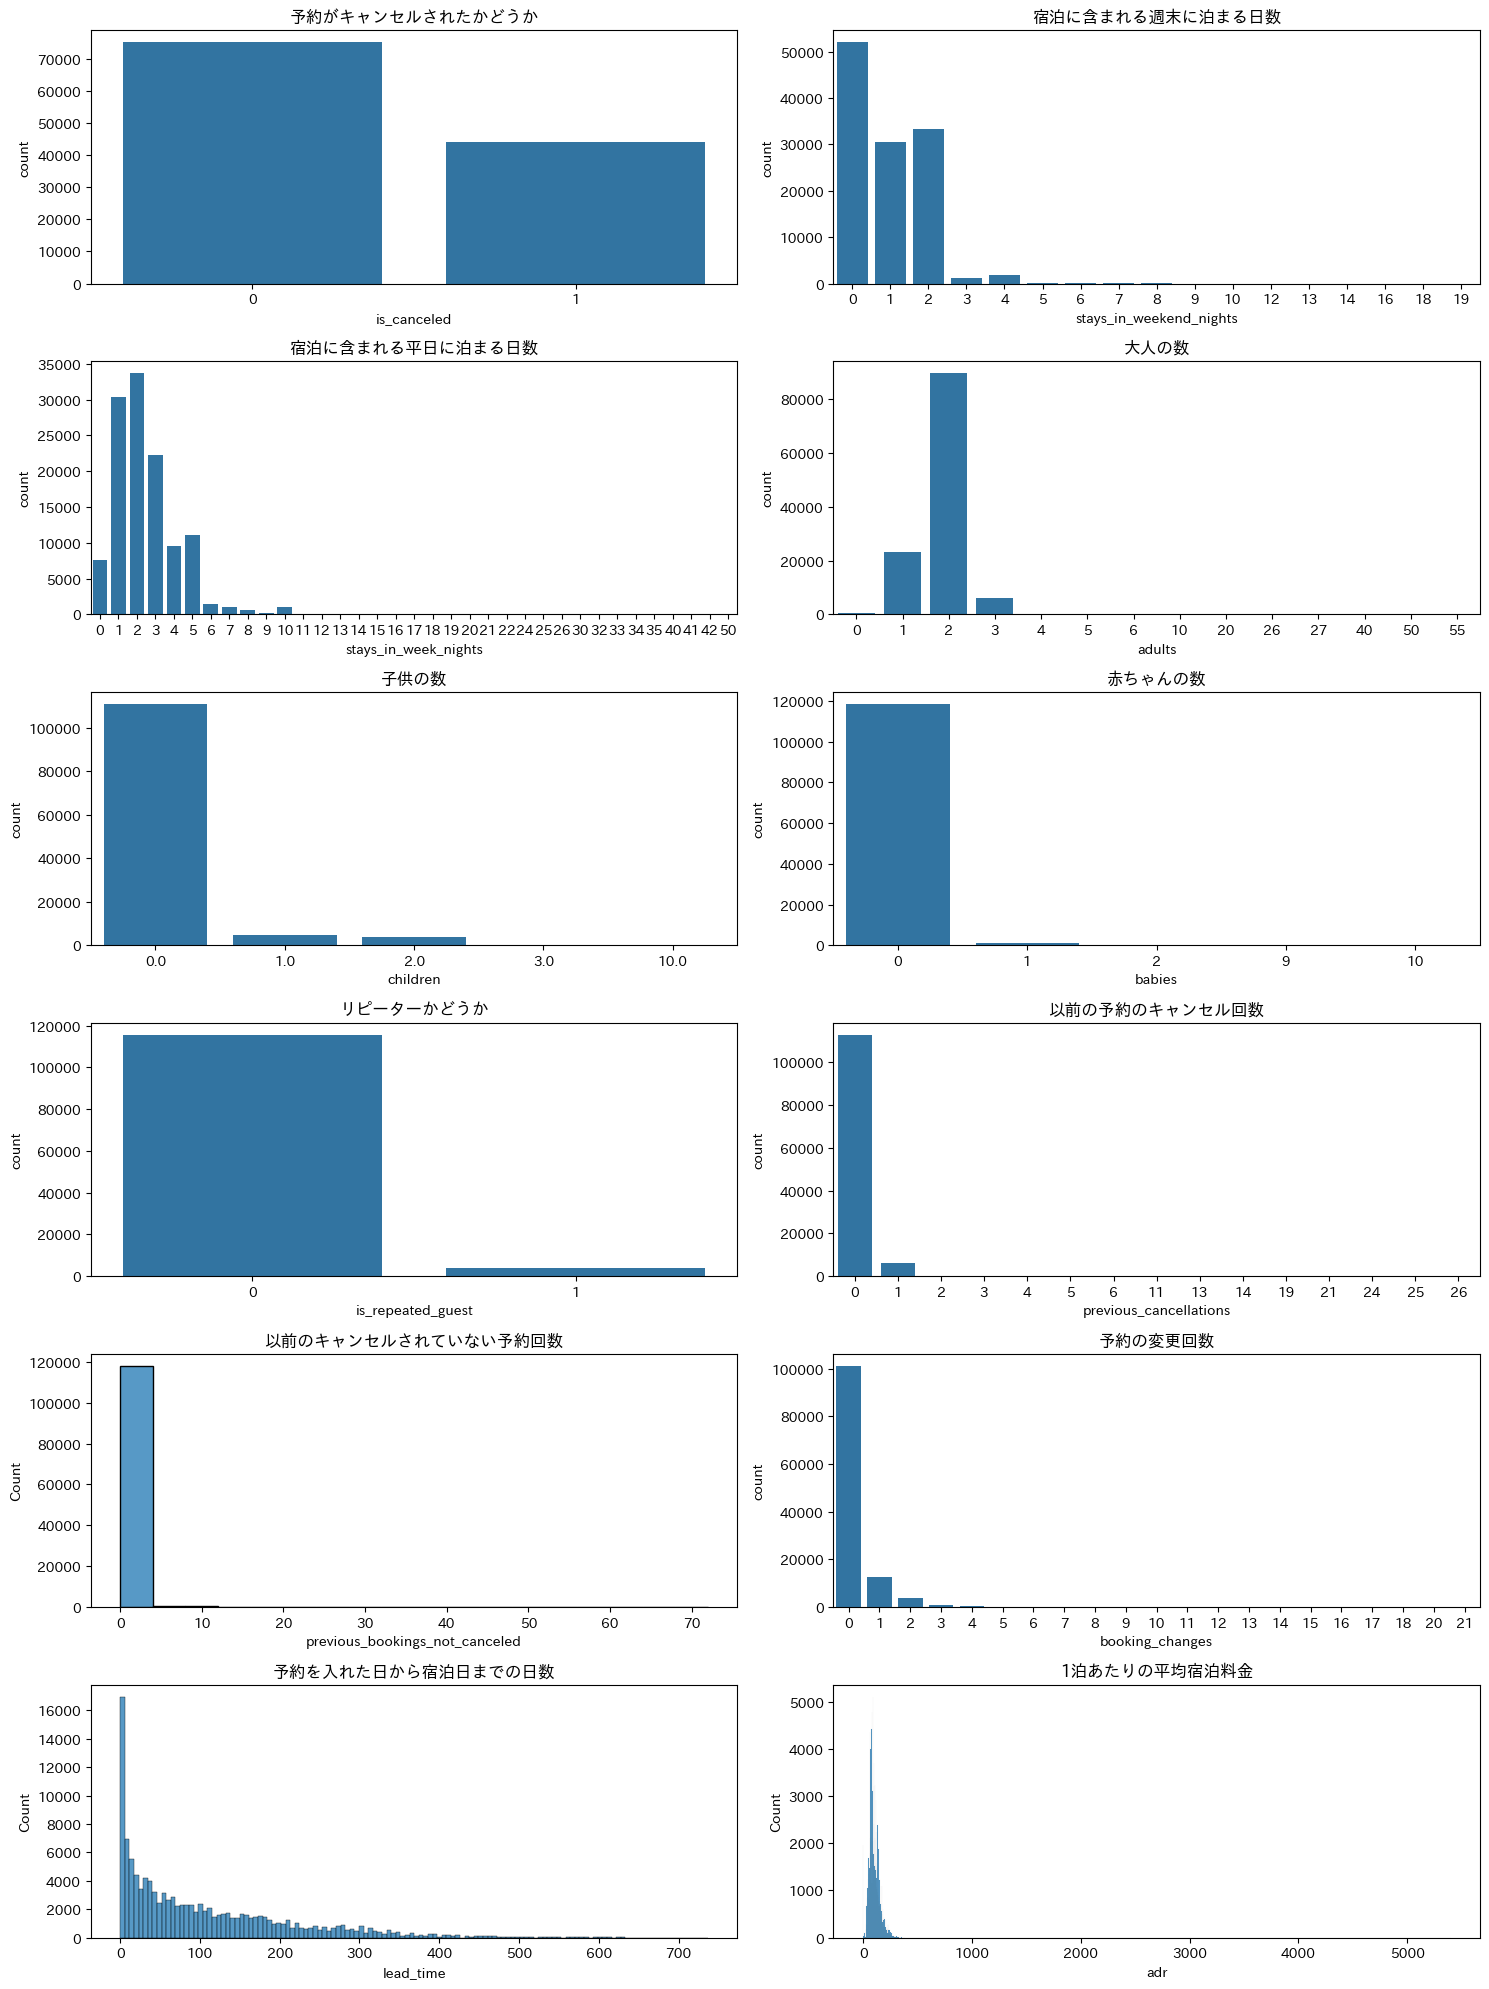

In [61]:
# Plot configurations
fig, axes = plt.subplots(6, 2, figsize=(15, 20))

# is_canceled
sns.countplot(x='is_canceled', data=df, ax=axes[0, 0])
axes[0, 0].set_title('予約がキャンセルされたかどうか')

#stays_in_weekend_nights
sns.countplot(x='stays_in_weekend_nights', data=df, ax=axes[0, 1])
axes[0, 1].set_title('宿泊に含まれる週末に泊まる日数')

#stays_in_week_nights
sns.countplot(x='stays_in_week_nights', data=df, ax=axes[1, 0])
axes[1, 0].set_title('宿泊に含まれる平日に泊まる日数')

#adults
sns.countplot(x='adults', data=df, ax=axes[1, 1])
axes[1, 1].set_title('大人の数')

#children
sns.countplot(x='children', data=df, ax=axes[2, 0])
axes[2, 0].set_title('子供の数')

#babies
sns.countplot(x='babies', data=df, ax=axes[2, 1])
axes[2, 1].set_title('赤ちゃんの数')

#is_repeated_guest
sns.countplot(x='is_repeated_guest', data=df, ax=axes[3, 0])
axes[3, 0].set_title('リピーターかどうか')

#previous_cancellations
sns.countplot(x='previous_cancellations', data=df, ax=axes[3, 1])
axes[3, 1].set_title('以前の予約のキャンセル回数')

#previous_bookings_not_canceled
sns.histplot(x='previous_bookings_not_canceled', data=df, ax=axes[4, 0])
axes[4, 0].set_title('以前のキャンセルされていない予約回数')

#booking_changes
sns.countplot(x='booking_changes', data=df, ax=axes[4, 1])
axes[4, 1].set_title('予約の変更回数')

#lead_time
sns.histplot(x='lead_time', data=df, ax=axes[5, 0])
axes[5, 0].set_title('予約を入れた日から宿泊日までの日数')

#adr
sns.histplot(x='adr', data=df, ax=axes[5, 1])
axes[5, 1].set_title('1泊あたりの平均宿泊料金')

plt.tight_layout()

次はカテゴリ系のカラムについてヒストグラムを確認してみます。

シティホテルの予約が多いことやたくさんの国から顧客が訪れていること、ビジネスタイプの部屋が多いことなどがわかります。

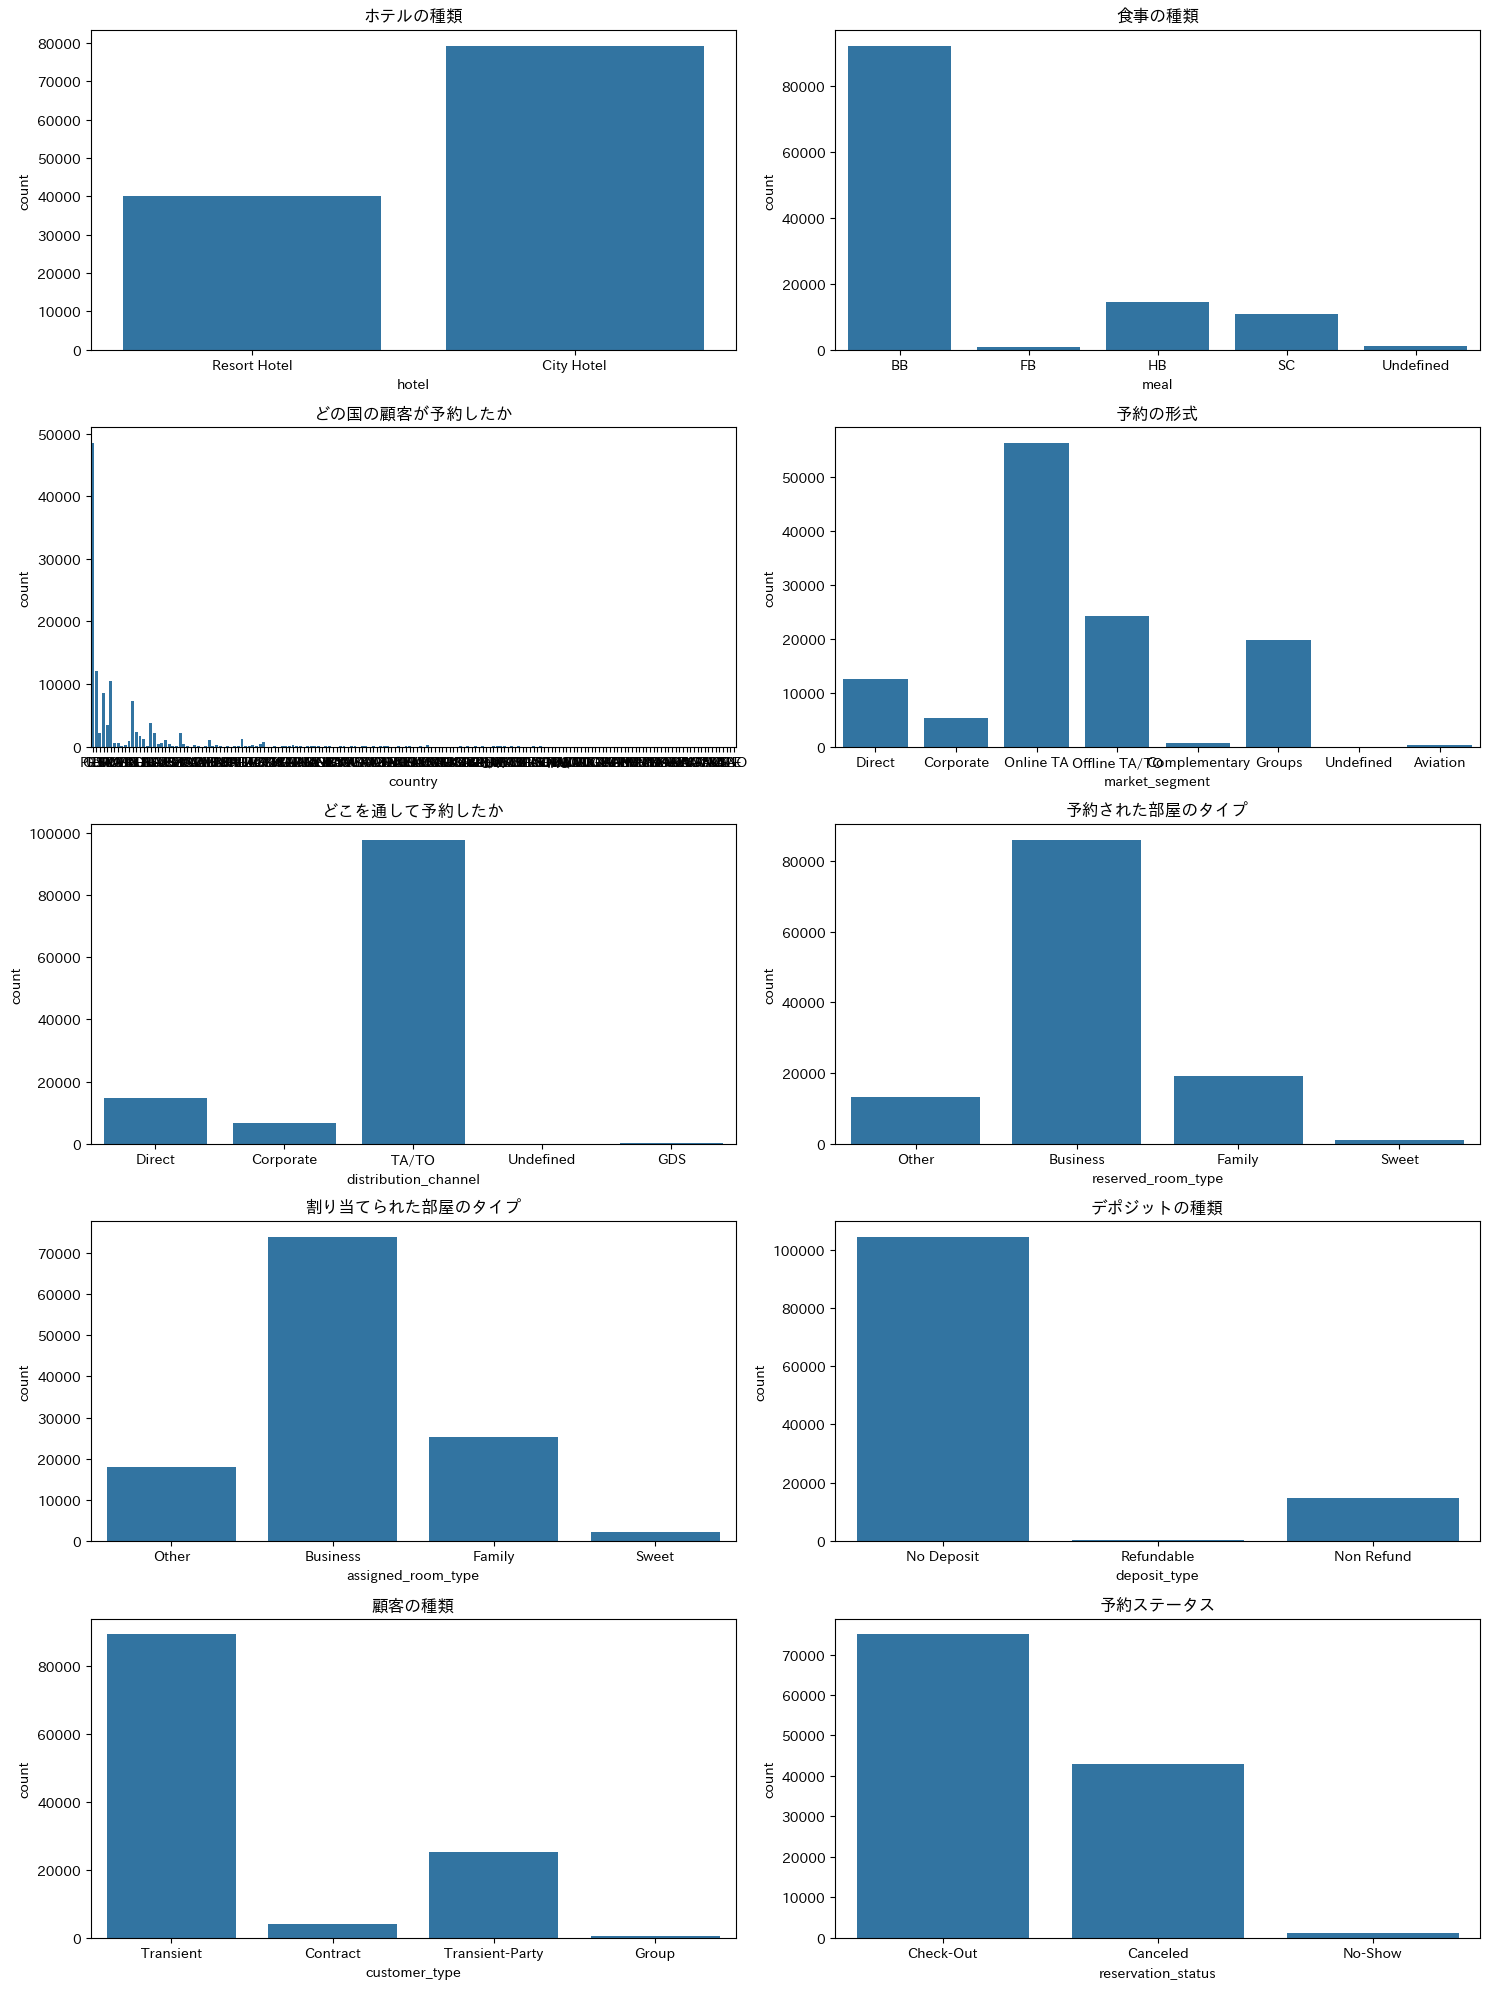

In [62]:
# Plot configurations
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

#hotel
sns.countplot(x='hotel', data=df, ax=axes[0, 0])
axes[0, 0].set_title('ホテルの種類')

#meal
sns.countplot(x='meal', data=df, ax=axes[0, 1])
axes[0, 1].set_title('食事の種類')

#country
sns.countplot(x='country', data=df, ax=axes[1, 0])
axes[1, 0].set_title('どの国の顧客が予約したか')

#market_segment
sns.countplot(x='market_segment', data=df, ax=axes[1, 1])
axes[1, 1].set_title('予約の形式')

#distribution_channel
sns.countplot(x='distribution_channel', data=df, ax=axes[2, 0])
axes[2, 0].set_title('どこを通して予約したか')

#reserved_room_type
sns.countplot(x='reserved_room_type', data=df, ax=axes[2, 1])
axes[2, 1].set_title('予約された部屋のタイプ')

#assigned_room_type
sns.countplot(x='assigned_room_type', data=df, ax=axes[3, 0])
axes[3, 0].set_title('割り当てられた部屋のタイプ')

#deposit_type
sns.countplot(x='deposit_type', data=df, ax=axes[3, 1])
axes[3, 1].set_title('デポジットの種類')

#customer_type
sns.countplot(x='customer_type', data=df, ax=axes[4, 0])
axes[4, 0].set_title('顧客の種類')

#reservation_status
sns.countplot(x='reservation_status', data=df, ax=axes[4, 1])
axes[4, 1].set_title('予約ステータス')

plt.tight_layout()

```country```のカラムはデータの種類が多いために見づらくなっています。そのため個別で内容について少し確認します。

In [63]:
df["country"].value_counts()

country
PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
DJI        1
BWA        1
HND        1
VGB        1
NAM        1
Name: count, Length: 177, dtype: int64

続いてサービスの評価をする上で重要となる数値(=目的変数)を考えてみましょう。例えば売上や利益のような数字があると、そのカラムを切り口に分析がしやすいと思われます。ここで市場分析に移ってもよいですが、今回はカラムの情報から考えてみましょう。

ここまでのEDAから見つかる目的変数としては、```is_canceled```（予約がキャンセルされたかどうか）が挙げられます。これは予約がキャンセルされるか否かを示す変数です。予約がキャンセルされるかどうかを予測することで、ホテルの予約管理や顧客サービスの最適化に役立つ可能性があるでしょう。

また、他に目的変数として考えられるものは、```adr```（平均支払い額）や```total_of_special_requests```（特別リクエストの合計数）なども考えられます。これらは顧客の支払い傾向やサービス要望に関する情報であり、ホテルのビジネス戦略やサービス提供の最適化に役立つかもしれません。

これら3つのカラムについて確認してみます。

ADRの値は極端な値があってグラフが読みにくかったため、X軸のADRの値を制限して表示します。

<Axes: title={'center': 'キャンセルかどうか'}, ylabel='count'>

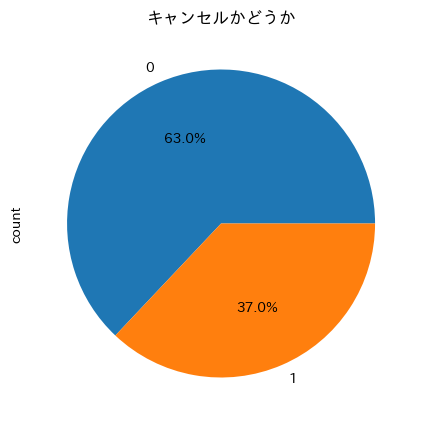

In [64]:
df["is_canceled"].value_counts().plot(kind="pie", autopct='%1.1f%%',title="キャンセルかどうか", figsize=(5, 5))

<Axes: title={'center': 'ADRの分布(上限500まで)'}, ylabel='Frequency'>

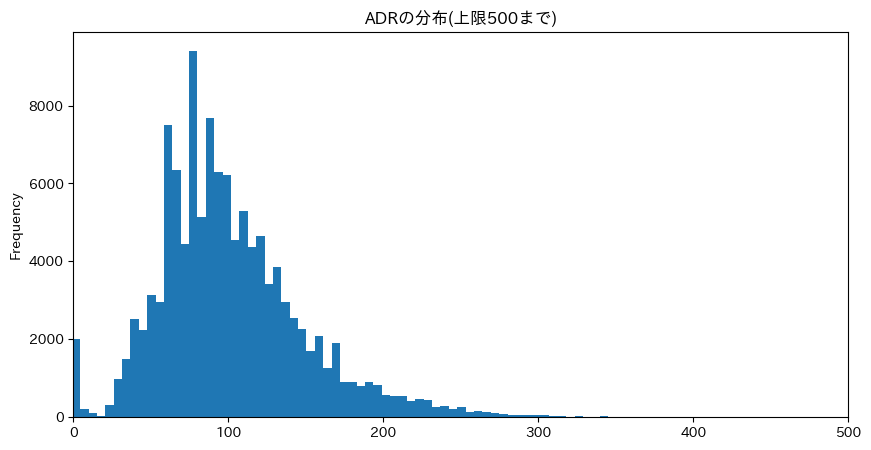

In [65]:
df["adr"].plot(kind="hist", bins=1000, figsize=(10, 5), title="ADRの分布(上限500まで)", xlim=(0, 500))

<Axes: title={'center': '特別リクエストの数'}, xlabel='total_of_special_requests'>

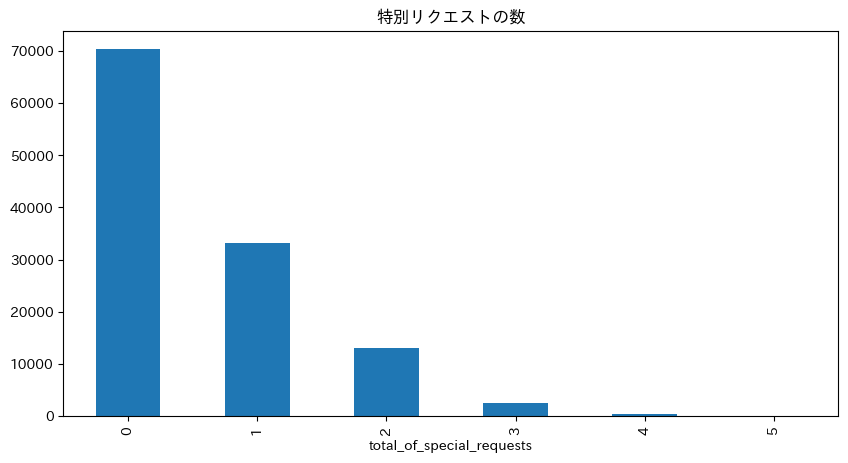

In [66]:
df["total_of_special_requests"].value_counts().plot(kind="bar", title="特別リクエストの数", figsize=(10, 5))


3つの変数を見たところ
- ```is_canceled```はキャンセル率が4割程度。
- ```adr```は50-100にボリュームゾーンがあり、0や数千といった極端な値も確認される。
- ```total_of_special_requests```は0,1が多くを占めている。

ということがわかりました。

# 2.課題仮説立案

ここでは課題仮説を立てていきます。ここまでのEDAから得られた情報を用いて立てていきます。現時点での具体性は低くても問題ありません。仮説立てと検証を繰り返していくことでより良い課題設定を目指します。

直前のEDAから課題仮説として、以下のようなものが考えられます。
- キャンセル率が高い
- 平均支払額が高い/低い
- 顧客のリクエストに対応できていない。

このnotebookではキャンセルを防ぐことが最もホテル側に利益があると考え

"**キャンセル率が高い**"ということに着目して進めていきます。

# 3.課題仮説検証

### 3-1.市場分析

ここでは外部データを参照しホテル業界におけるキャンセル率がどのようになっているかを確認します。

このデータはポルトガルのホテルの予約のデータになっています。そこで、今回はD-Edge社が提供する[2014年から2018年のヨーロッパの680のホテルについて調査したキャンセル率](https://hospitalitytech.com/global-cancellation-rate-hotel-reservations-reaches-40-average)を市場のデータとして活用してみましょう。

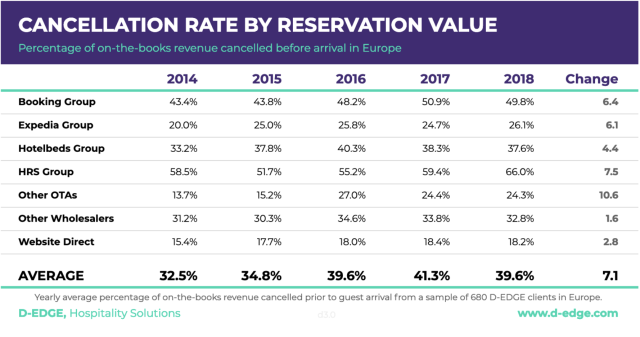

In [ ]:
image = Image.open(path +'/cancel.png')
display(image)

こちらの記事には、”年々キャンセル率が上昇していることによってホテルの収益と経営管理に非常にネガティブな影響がある”と述べられています。また、今回分析したデータセットのキャンセル率は平均キャンセル率程度であり、十分に改善する余地があるといえます。

そこでホテル業界におけるキャンセル率の改善をはかる事業提案をしてみましょう。

### 3-2.EDA

#### 3-2-1.キャンセル率とほかのカラムの関係

ここでは、```is_canceled```と他のカラムとの相関係数を確認したりとより詳しくEDAを行っていきます。

ここからどのような要素がキャンセルと関連が深いか確認することで具体的な事業提案の内容を考えていきます。

ホテルのタイプとキャンセル数の関係性としては
- シティホテルの方がキャンセル数が多い
- シティホテルの方が予約数が多い

ということがわかります。

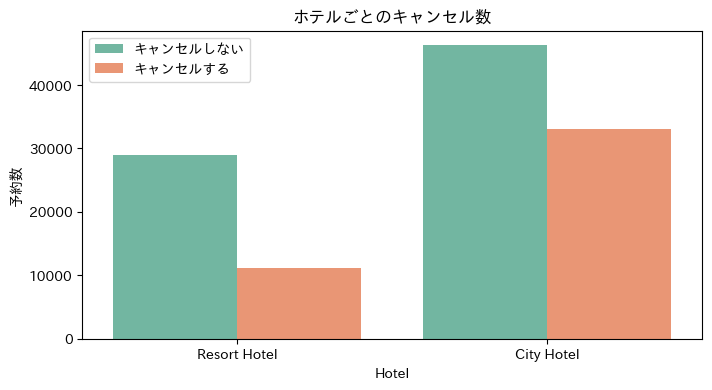

In [67]:
plt.figure(figsize=(8, 4))
ax1 = sns.countplot(x='hotel', hue='is_canceled', data=df, palette="Set2")
plt.title('ホテルごとのキャンセル数')
plt.xlabel('Hotel')
plt.ylabel('予約数')
plt.legend(['キャンセルしない', 'キャンセルする'])
plt.show()

相関係数の大きなデータはキャンセルに関与している可能性が高いと考えられます。相関係数が大きいカラムを3つチェックしてみましょう

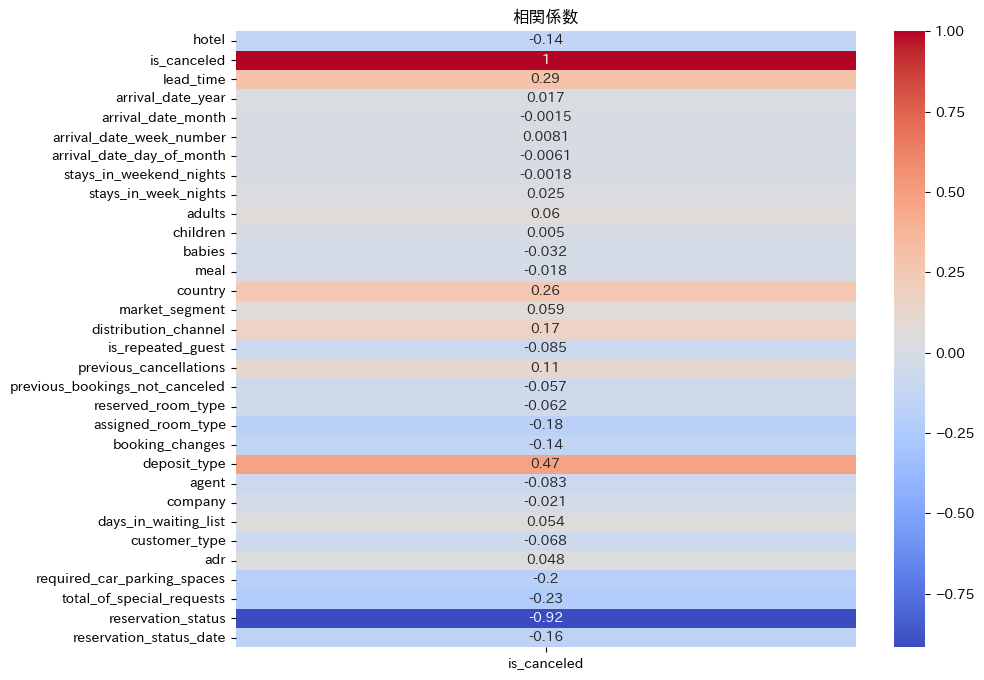

In [68]:
df_ = copy.deepcopy(df)
label_encoder = LabelEncoder()
object_columns = df.select_dtypes(include=['object']).columns
for column in object_columns:
    df_[column] = label_encoder.fit_transform(df[column])
corr_matrix = df_.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['is_canceled']], annot=True, cmap='coolwarm')
plt.title('相関係数')
plt.show()

上記から"reservation_status","deposit_type","lead_time"に着目します。

まず"reservation_status"に関して、キャンセルとの関連性を見ていきます。

In [69]:
print(df["reservation_status"].value_counts())
print(df[df["reservation_status"]=="Check-Out"]["is_canceled"].value_counts())
print(df[df["reservation_status"]=="Canceled"]["is_canceled"].value_counts())
print(df[df["reservation_status"]=="No-Show"]["is_canceled"].value_counts())

reservation_status
Check-Out    75166
Canceled     43017
No-Show       1207
Name: count, dtype: int64
is_canceled
0    75166
Name: count, dtype: int64
is_canceled
1    43017
Name: count, dtype: int64
is_canceled
1    1207
Name: count, dtype: int64


最も相関係数の大きい```reservation_status```は最終的に予約通りに顧客が来たか否かを表すカラムであるという説明である通り、キャンセルに関する顧客情報には関与しないでしょう。

続いて、"deposit_type"について可視化します。

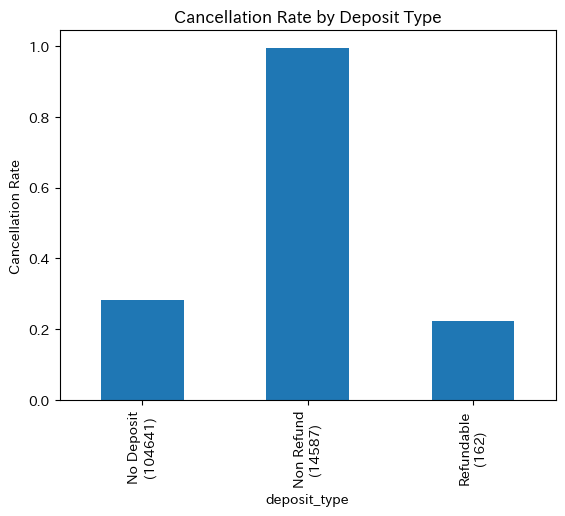

In [70]:
group_counts = df.groupby('deposit_type')['is_canceled'].count()
cancel_rates = df.groupby('deposit_type')['is_canceled'].mean()
fig, ax = plt.subplots()
cancel_rates.plot(kind='bar', ax=ax)
ax.set_xticklabels([f'{label}\n({count})' for label, count in zip(cancel_rates.index, group_counts)])

plt.title('Cancellation Rate by Deposit Type')
plt.ylabel('Cancellation Rate')
plt.show()

```deposit_type```の各要素の説明を見てみると

No Deposit (入金なし) - デポジットなし。

Non Refun (返金不可) - 宿泊費と同等のデポジット。

Refundable (払い戻し可能) - 宿泊費より少ないデポジット。

このカラムについては返金不可であるにもかかわらずキャンセル率が非常に高いです。本来であればキャンセル料がとられるならば慎重に予約すると思われます。


最後に"is_canceled"について可視化を行います。

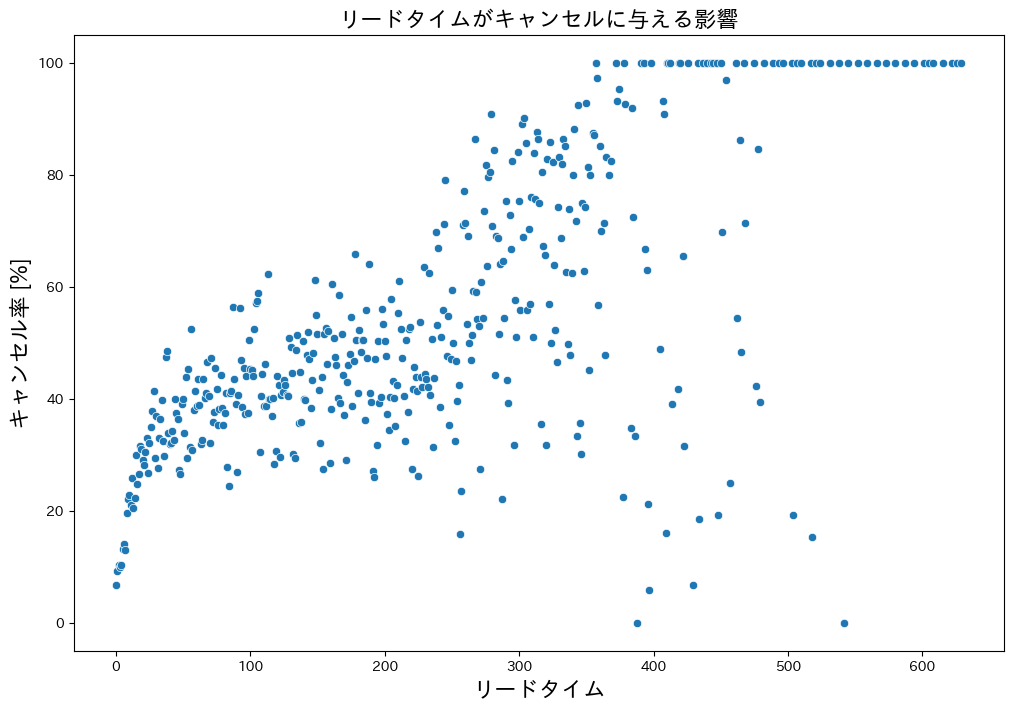

In [71]:
# lead_timeに基づいてデータをグループ化する：
lead_cancel_data = df.groupby("lead_time")["is_canceled"].describe()
# 極端な値等を避けるために、10回以上の予約があるlead_timeのみを使用してグラフを作成する
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

plt.figure(figsize=(12, 8))
sns.scatterplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("リードタイムがキャンセルに与える影響", fontsize=16)
plt.xlabel("リードタイム", fontsize=16)
plt.ylabel("キャンセル率 [%]", fontsize=16)
plt.show()

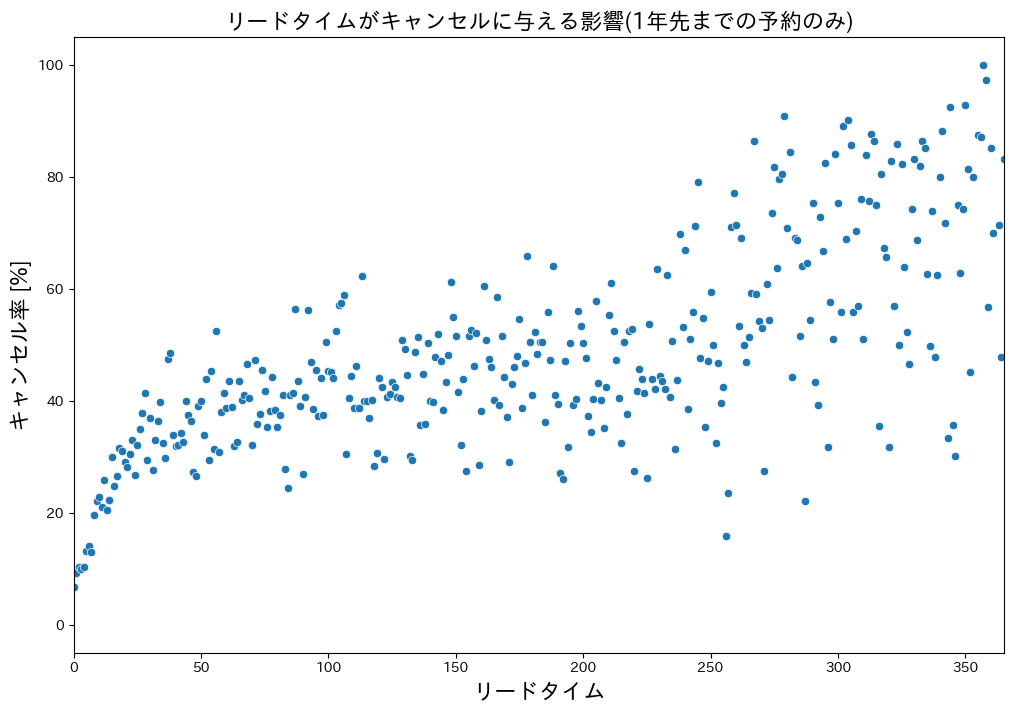

In [72]:
lead_cancel_data = df.groupby("lead_time")["is_canceled"].describe()
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

plt.figure(figsize=(12, 8))
sns.scatterplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("リードタイムがキャンセルに与える影響(1年先までの予約のみ)", fontsize=16)
plt.xlabel("リードタイム", fontsize=16)
plt.ylabel("キャンセル率 [%]", fontsize=16)
plt.xlim(0,365)
plt.show()

```lead_time```が長くなるにつれてキャンセル率が高くなる傾向が読み取れます。

先の予約可能な日付を短くするといったことを行うとキャンセル率を下げる可能性がありそうです。

軽くEDAをすることでキャンセルに関する様々な情報が得られました。まずは```deposit_tyoe```の違和感についてより詳しくEDAをしてみましょう。

#### 3-2-2.```deposit_tyoe```に関するEDA

ここでは```deposit_tyoe```と```is_canceled```の関係性についてより詳しく見てみます。

返金不可でもキャンセルをするような状況についてどのような状況があるか考えてみましょう。思いつくようなこととしては

**1** 天候や交通の影響: 悪天候や交通機関の遅延など、外部の要因により旅行計画が変更される場合。

**2** 予定変更の必要性: 予定されたイベントや会議の変更が発生し、日程を調整する必要がある場合。

今回のデータセットからは1の検証はできないでしょう。そのため、2を想定しつつEDAをしてみましょう。

全体の要素と```Non Refund```の行の要素で大きく変化しているカラムは以下の4つがありました。
- ```children```

- ```customer_type```

- ```booking_changes```

- ```lead_time```

これらのカラムに着目し、詳しく見ていきましょう

In [73]:
# 顧客タイプについて
df["kids"] = df["children"] + df["babies"]
df_non_refund = df[df['deposit_type'] == 'Non Refund']
df_not_non_refund = df[df['deposit_type'] != 'Non Refund']

初めに顧客タイプについて確認してみましょう。
```customer_type```の要素は以下の通りです。

contract - 他の予約に関連付けられている

Group - 予約がグループに関連付けられている

Transient - いずれの予約とも関連していない

Transient-party - グループではなく、他の個別予約と関連している



Transientの割合がやや高くなっています。グループでの予約も見られないようです。

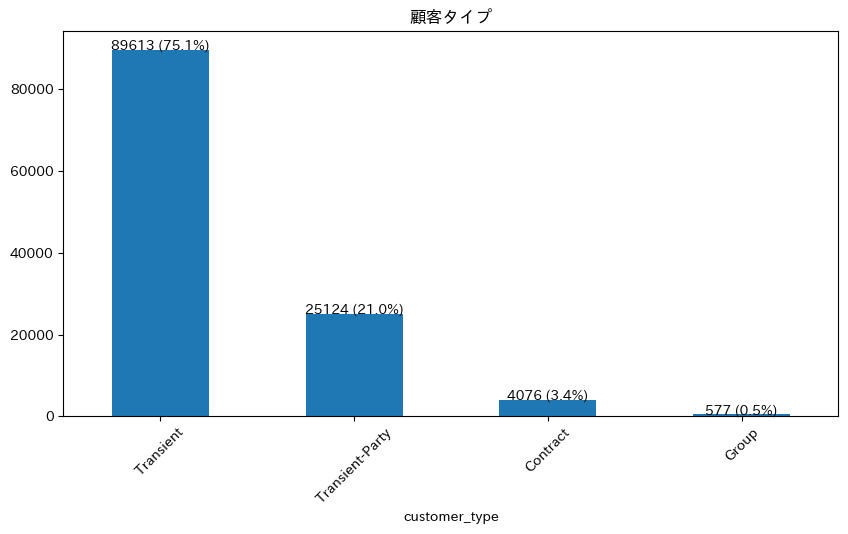

In [74]:
ax = df["customer_type"].value_counts().plot(kind="bar", title="顧客タイプ", figsize=(10, 5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
for i, v in enumerate(df["customer_type"].value_counts()):
    ax.text(i, v + 0.1, f"{v} ({v / len(df) * 100:.1f}%)", ha="center")

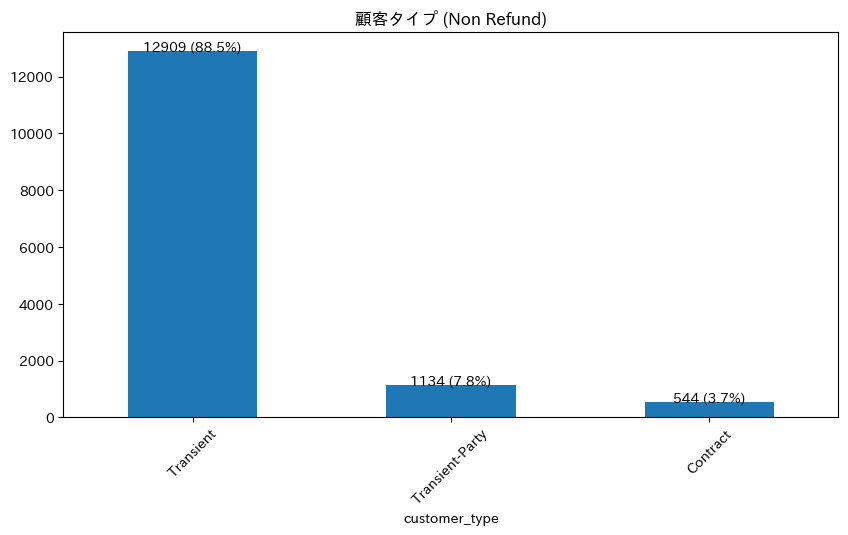

In [75]:
ax = df_non_refund["customer_type"].value_counts().plot(kind="bar", title="顧客タイプ (Non Refund)", figsize=(10, 5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
for i, v in enumerate(df_non_refund["customer_type"].value_counts()):
    ax.text(i, v + 0.1, f"{v} ({v / len(df_non_refund) * 100:.1f}%)", ha="center")

```childlen```のカラムでも大きく差がありました。```Non refund```に含まれる顧客情報は家族などのグループは少ないのではないのでしょうか。この点をみてみましょう。

平均した大人の予約人数はあまり変わらないようですが、平均した子供の予約人数は非常に少ないようです。

家族連れが少ない可能性が高そうです。

In [76]:
print("データセット全体の平均の子供数：" + f"{df['kids'].mean():.3f}")
print("Non refundとなっているデータの平均の子供数:" + f"{df_non_refund['kids'].mean():.3f}")

データセット全体の平均の子供数：0.112
Non refundとなっているデータの平均の子供数:0.001


In [77]:
print("データセット全体の平均大人の数：" + f"{df['adults'].mean():.3f}")
print("Non refundとなっているデータの平均大人の数:" + f"{df_non_refund['adults'].mean():.3f}")

データセット全体の平均大人の数：1.856
Non refundとなっているデータの平均大人の数:1.811


```room_type```はほとんどBussinessであることがわかりました。
家族連れが少なく部屋のタイプがBussinessということはまさにビジネスパーソンがホテルの予約をしてキャンセルをしている可能性が高そうです。

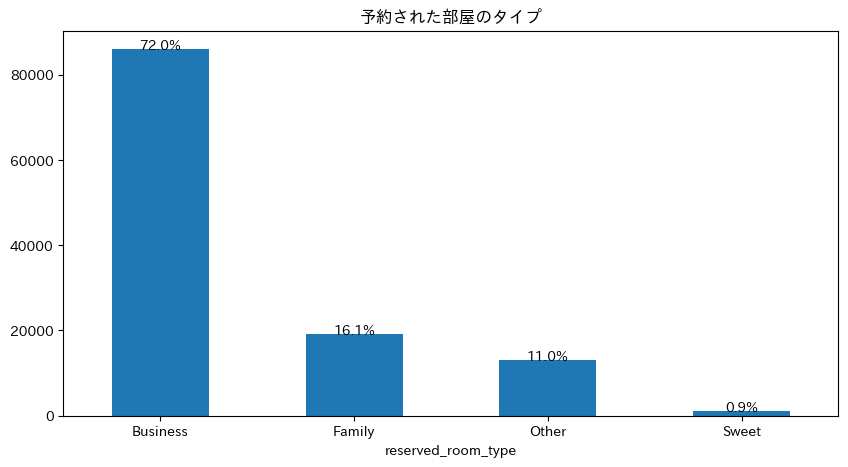

In [78]:
ax = df["reserved_room_type"].value_counts().plot(kind="bar", title="予約された部屋のタイプ", figsize=(10, 5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for i, v in enumerate(df["reserved_room_type"].value_counts()):
    ax.text(i, v + 0.1, f"{v / len(df) * 100:.1f}%", ha="center")

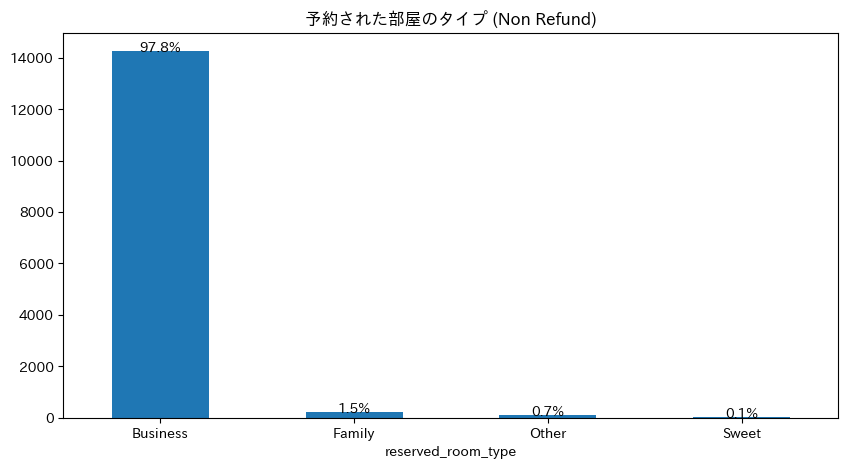

In [79]:
ax = df_non_refund["reserved_room_type"].value_counts().plot(kind="bar", title="予約された部屋のタイプ (Non Refund)", figsize=(10, 5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for i, v in enumerate(df_non_refund["reserved_room_type"].value_counts()):
    ax.text(i, v + 0.1, f"{v / len(df_non_refund) * 100:.1f}%", ha="center")

```lead_time```の分布については極端な偏りは見られないようです。しかし、泊まる日の直前の予約は少なく、以前から予約されているものが多いことがわかります。

<Axes: title={'center': 'リードタイムの分布 (Non Refund)'}, ylabel='Frequency'>

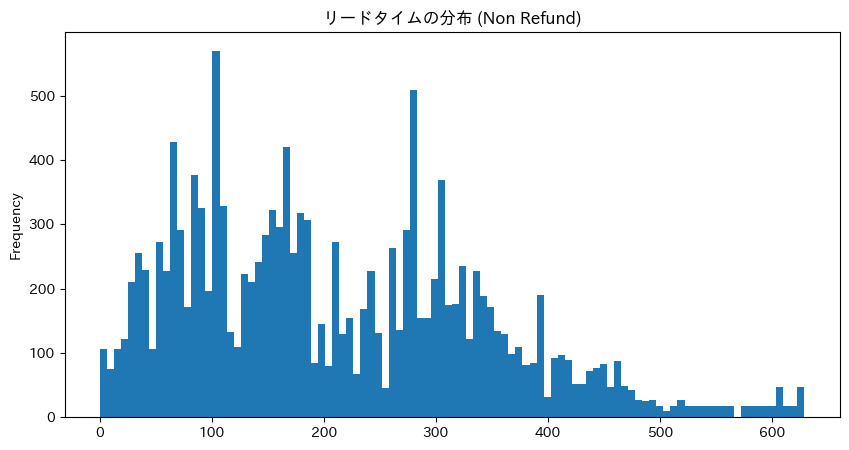

In [80]:
df_non_refund["lead_time"].plot(kind="hist", bins=100, figsize=(10, 5), title="リードタイムの分布 (Non Refund)")

In [81]:
df_lead = pd.DataFrame()
df_lead["ALL"] = df["lead_time"].describe()
df_lead["NON REFUND"] = df_non_refund["lead_time"].describe()
df_lead

,ALL,NON REFUND
count,119390.000,14587.000
mean,104.011,212.909
std,106.863,133.324
min,0.000,0.000
25%,18.000,103.000
50%,69.000,183.000
75%,160.000,304.000
max,737.000,629.000


ここまでEDAをすると、
- 顧客タイプはグループでない
- 顧客に家族連れが少ない
- ルームタイプはビジネス向けが大多数を占める
- 通常に比べより早い段階から予約が行われている

この情報から判断すると、おそらくビジネス旅行者が多いと推測できます。顧客がグループでなく、家族連れが少ないことから、個人やビジネス関連の旅行が主体である可能性が高いです。また、ビジネス向けのルームタイプが多いことからも、ビジネス関連の目的での宿泊が増えていると考えられます。さらに、予約が通常よりも早い段階から行われているという情報からは、計画されたビジネスイベントや会議などのために旅行が行われている可能性が高いでしょう。

ここから考えられる施策はどのようなものがあるでしょうか。

- 会社を通しての予約は直前にしかできないようにする。
- 今までキャンセル料を取っていないビジネスマンによる予約を、キャンセル料を取るようにする。

しかしこれらの施策は現実的でなかったり、定量的評価は非常に難しかったりします。一案として持ちながら、他の施策を打てないか探してみましょう。

#### 3-2-3.データの時系列に着目

このデータセットには各予約がいつ行われたか、いつの宿泊予約であるかの情報が含まれています。

そこで、予約月、宿泊月ごとにキャンセル数がどのように分布しているか確認してみましょう。

In [82]:
# 宿泊日のデータを扱いやすい形に変更
df['arrival_date'] = pd.to_datetime(df[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']].astype(str).agg('-'.join, axis=1))
df["reservation_status_date"] = pd.to_datetime(df["reservation_status_date"])
df_cancel = df[df["is_canceled"] == 1]

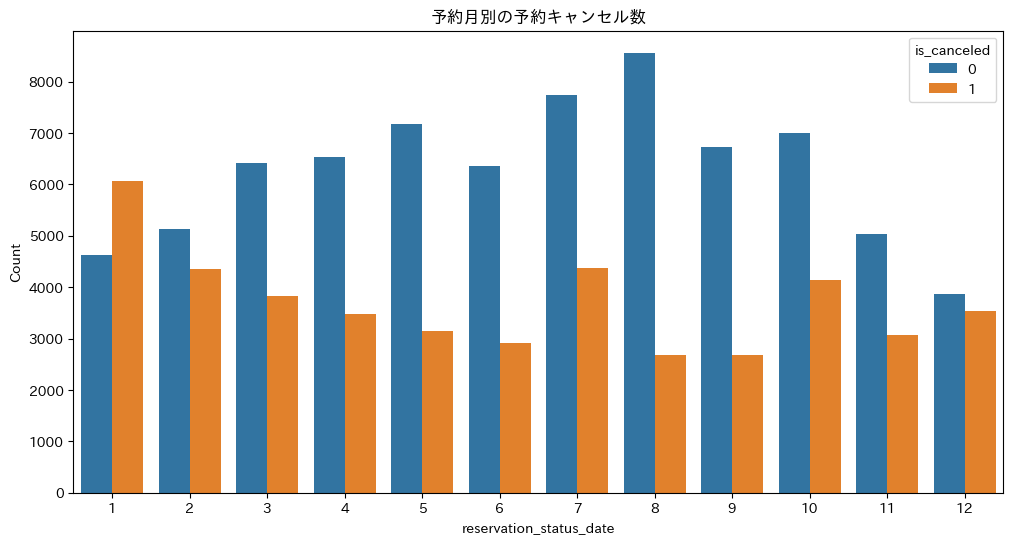

In [83]:
df["reservation_status_month"] = df["reservation_status_date"].dt.month
plt.figure(figsize=(12, 6))
sns.countplot(x='reservation_status_month', hue='is_canceled', data=df)
plt.title('予約月別の予約キャンセル数')
plt.xlabel('reservation_status_date')
plt.ylabel('Count')
plt.show()

In [84]:
df.groupby("reservation_status_month")["is_canceled"].mean()

reservation_status_month
1    0.567
2    0.459
3    0.373
4    0.347
5    0.305
6    0.314
7    0.361
8    0.239
9    0.285
10   0.372
11   0.378
12   0.477
Name: is_canceled, dtype: float64

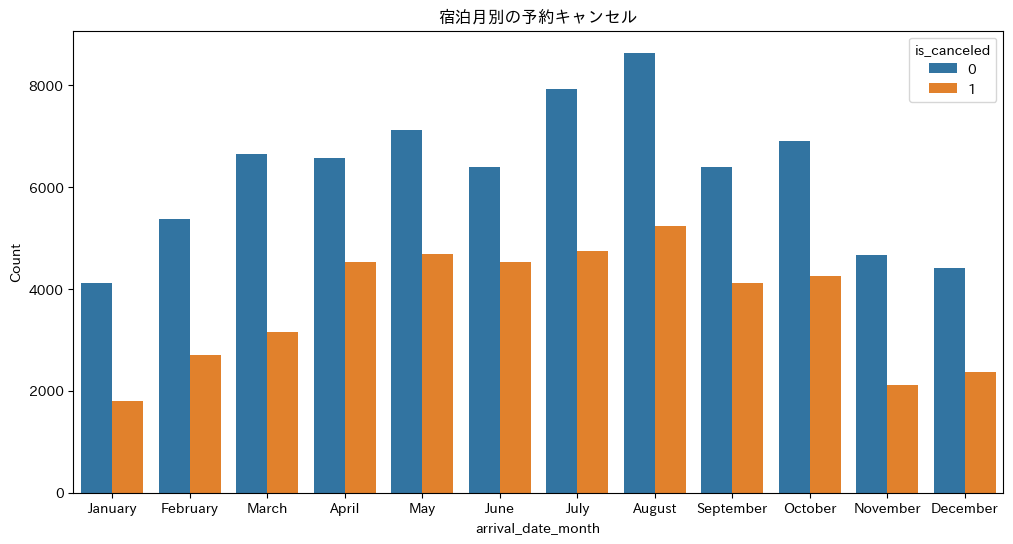

In [85]:
plt.figure(figsize=(12, 6))
sns.countplot(x='arrival_date_month', hue='is_canceled', data=df, order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title("宿泊月別の予約キャンセル")
plt.xlabel('arrival_date_month')
plt.ylabel('Count')
plt.show()

In [86]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df.groupby("arrival_date_month")["is_canceled"].mean().reindex(month_order)

arrival_date_month
January     0.305
February    0.334
March       0.322
April       0.408
May         0.397
June        0.415
July        0.375
August      0.378
September   0.392
October     0.380
November    0.312
December    0.350
Name: is_canceled, dtype: float64

この分布を見てみると
- 1,7,10月に行われた予約のキャンセル数が多い。
- 4~7月の宿泊の予約のキャンセル数が多い。

割合をみると
- 10~3月に行われた予約のキャンセル数が多い。
- 4-10月の宿泊の予約のキャンセル数が多い。

ということが読み取れます。

これに加えて、宿泊月と関連していそうな要素として宿泊料金についても見てみましょう。

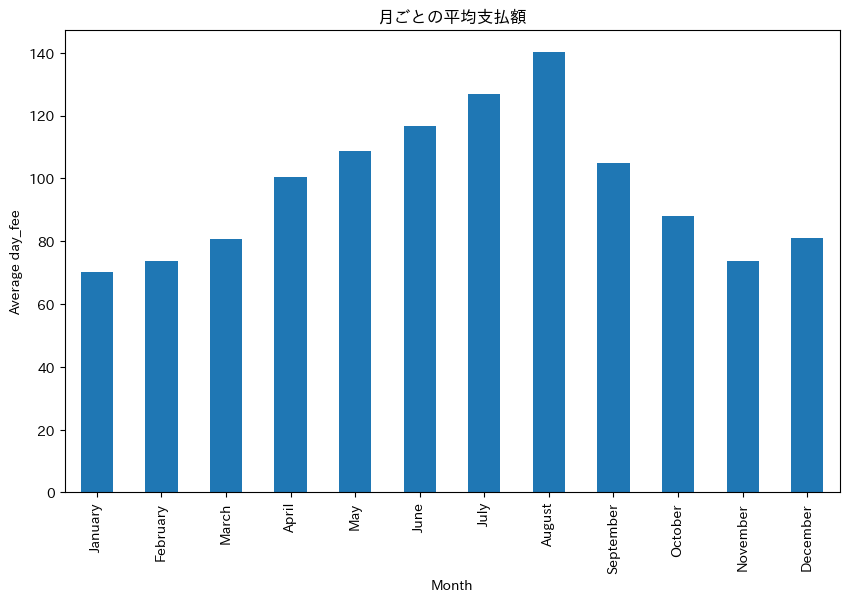

In [87]:
df['arrival_date_month'] = pd.Categorical(df['arrival_date_month'], categories=month_order, ordered=True)

# 月ごとの day_fee の平均を計算
monthly_avg = df.groupby('arrival_date_month')['adr'].mean()

# グラフのプロット
fig, ax = plt.subplots(figsize=(10, 6))
monthly_avg.plot(kind='bar', ax=ax)

ax.set_xlabel('Month')
ax.set_ylabel('Average day_fee')
ax.set_title('月ごとの平均支払額')
plt.show()

宿泊月のキャンセル数と料金の分布が似ているように見えます。この点を相関係数によって有意差があるか検定してみましょう。

今回の帰無仮説は「キャンセル数と料金に相関がない」です。
p値が小さければこの仮説が棄却され、相関があるということが証明できます。

In [88]:
new_df = df[["arrival_date_month",'adr', 'is_canceled']].groupby('arrival_date_month').mean()
corr_coef, p_value = stats.pearsonr(new_df['adr'], new_df['is_canceled'])
print(f'Correlation coefficient: {corr_coef:.3f}')
print(f'P-value: {p_value:.3f}')

Correlation coefficient: 0.720
P-value: 0.008


P値が0.01未満であることから相関がないという仮説が否定され、月ごとのキャンセル数と料金には相関があるといえます。

しかし、これだけでadrに関連した改善案を提案するという考えでは不十分です。

キャンセルされた場合のadrとそれ以外のadrに有意差がなければその変数にアプローチをすることはあまり有用といえないでしょう。

In [89]:
t_statistic, p_value = stats.ttest_ind(df_cancel.groupby("arrival_date_month")["adr"].mean(), df.groupby("arrival_date_month")["adr"].mean())
print(f't検定統計量: {t_statistic:.2f}')
print(f'p値: {p_value:.5f}')

t検定統計量: 0.30
p値: 0.76620


p値は0.01を超えているため有意差はありません。

料金は宿泊月のキャンセルに影響を及ぼしそうですが、キャンセルされた場合とそれ以外のadrで有意差がないため打ち手を出しても効果が少ないかもしれません。

予約日時と宿泊日時の差について見てみましょう。lead_timeカラムがこれを確認するのに適しています。

In [90]:
df_cancel = df[df["is_canceled"] == 1]
df_lead_month = pd.DataFrame()
df_lead_month["all"] = pd.Series(df.groupby("reservation_status_month")["lead_time"].mean())
df_lead_month["cancel"] = pd.Series(df_cancel.groupby("reservation_status_month")["lead_time"].mean())
df_lead_month

,all,cancel
reservation_status_month,,
1,104.305,154.802
2,71.597,120.579
3,82.769,137.879
4,93.017,129.163
5,101.222,117.551
6,116.264,136.253
7,137.011,171.091
8,108.447,130.109
9,106.010,122.578


こちらも全体の値とキャンセルで差がありそうに見えます。
今度はt検定を行ってみましょう。

In [91]:
t_statistic, p_value = stats.ttest_ind(df_lead_month["all"],df_lead_month["cancel"])
print(f't検定統計量: {t_statistic:.2f}')
print(f'p値: {p_value:.5f}')

t検定統計量: -3.32
p値: 0.00310


```lead_time```はキャンセルか否かで有意差が見られました。```lead_time```へのアプローチは有効そうです。

### 3-3.```is_canceled```を目的変数としてモデル作成、寄与度などを確認

```is_canceled```を目的変数とした予測モデルを作成し、説明変数の重要度分析を行い、これまでのEDAや市場分析で得られた情報と合わせ、打ち手仮説立案に繋げていきます。

今回の機械学習モデルの作成はobject型のデータを除く28のカラムを使って行います。また、ハイパーパラメータはoptunaを使って調整しました。

実際の最終課題ではコンペティションのように自身でカラムを作成する特徴量エンジニアリングなどを行うとよいです。

以下のモデルは学習の結果AUCが92%のかなり高精度のモデルが作成できました。
合わせて最もデータをよく表す閾値を探索します。

In [ ]:
#再度データを読み込み、object型のデータを除外
df_train = pd.read_csv(path +'/hotel_bookings.csv')
df_train = df_train.select_dtypes(exclude=['object'])

In [43]:
features = df_train.drop(columns=[ 'is_canceled',  'arrival_date_year',
       'arrival_date_week_number',
       'arrival_date_day_of_month', ])
target = df_train['is_canceled']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

train_set = lgb.Dataset(X_train, y_train)
test_set = lgb.Dataset(X_test, y_test)

#パラメータ設定

params = {'objective': 'binary',
 'metric': 'auc',
 'random_state': 42,
 'early_stopping_round': 10,
 'feature_pre_filter': False,
 'lambda_l1': 3.6220197651842656e-05,
 'lambda_l2': 0.0009871568791219231,
 'num_leaves': 251,
 'feature_fraction': 0.6799999999999999,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 5,
 'num_iterations': 1000}

#学習
model = lgb.train(
    params = params,
    train_set = train_set,
    valid_sets = [test_set],
)
y_pred = model.predict(X_test)  # Replace X_test with your test data
auc = roc_auc_score(y_test, y_pred)

print("AUC:", auc)

[LightGBM] [Info] Number of positive: 35253, number of negative: 60259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 95512, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369095 -> initscore=-0.536101
[LightGBM] [Info] Start training from score -0.536101
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[290]	valid_0's auc: 0.921893
AUC: 0.9218931648879389


In [44]:
#最適な閾値の検索
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

Optimal threshold: 0.35290912137011393


モデルがどのような変数を重要視して学習したかも確認しましょう。

今回のモデルでは、```adr```、```lead_time```が良く学習された変数であることがわかります。
機械学習モデルからもこれらの```lead_time```へのアプローチは有用といえるでしょう。

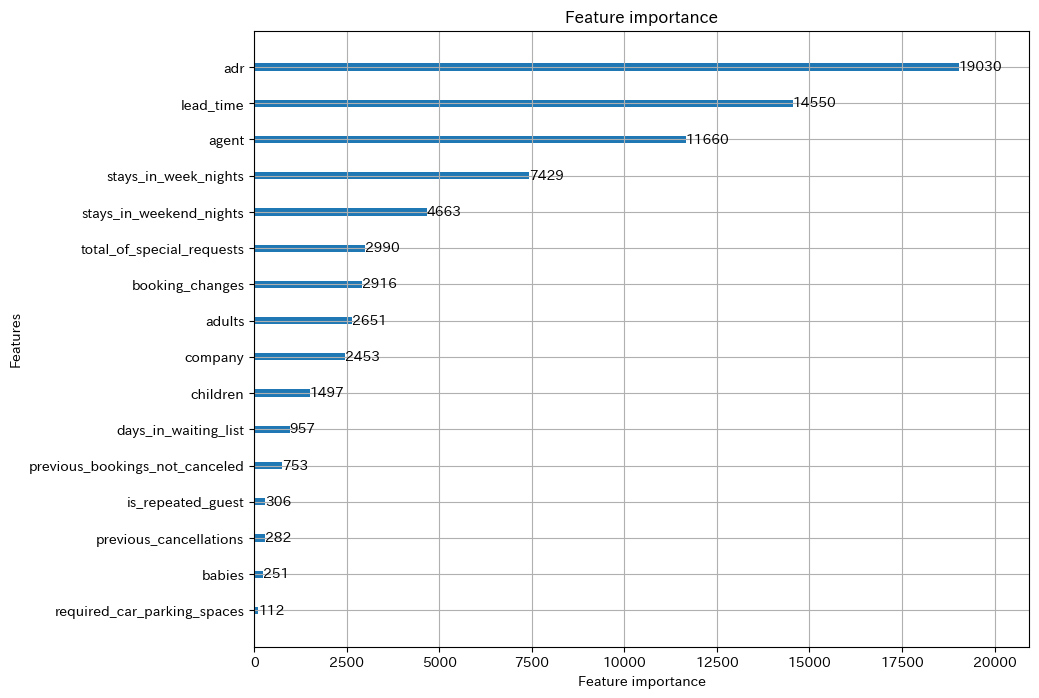

In [45]:
lgb.plot_importance(model, figsize=(10, 8))
plt.show()

# 4.打ち手仮説立案

```lead_time```に関してどのような事業提案が考えられるでしょうか。

初めのEDAで```lead_time```の値が大きければ大きいほどキャンセルの可能性が高いことがわかりました。すなわち、先の予約可能な日付を短くするといったことを行うとキャンセル率が下がると考えられます。
この提案は実際にキャンセル率を下げる効果が期待できますが、せっかくですので、詳細なEDAの結果も活用してみましょう。


```lead_time```を月ごとに見ると、10-3月において```lead_time```が全体と比較して日以40上大きくなっています。また、EDAから10-3月に行われた予約のキャンセル数が多いということも分かっています。

そこで、今回は"**10-3月に予約する際には先の予約可能な日付を短くする。具体的には、キャンセルされた予約の平均と全体の平均の比から短くする範囲を指定する**"という提案をしてみましょう。

今回は先の予約可能な日付を7割程度まで短くするという提案になります。

In [46]:
df.groupby("reservation_status_month")["is_canceled"].mean()

reservation_status_month
1    0.567
2    0.459
3    0.373
4    0.347
5    0.305
6    0.314
7    0.361
8    0.239
9    0.285
10   0.372
11   0.378
12   0.477
Name: is_canceled, dtype: float64

In [47]:
df_lead_month["cancel"]-df_lead_month["all"]

reservation_status_month
1    50.497
2    48.982
3    55.110
4    36.147
5    16.329
6    19.990
7    34.080
8    21.662
9    16.567
10   86.406
11   43.073
12   45.636
dtype: float64

In [48]:
df['lead_time'].mean() / df_cancel['lead_time'].mean()

0.7180688104227855

# 5.打ち手仮説検証

In [50]:
df_pred = pd.read_csv(path +'/hotel_bookings.csv')
df_pred["reservation_status_month"] = pd.to_datetime(df_pred["reservation_status_date"]).dt.month
df_cancel = df_pred[df_pred["is_canceled"] == 1]
df_pred.loc[df_pred['reservation_status_month'].isin([1,2,3,10,11,12]), 'lead_time'] = df_pred['lead_time'] * (df['lead_time'].mean() / df_cancel['lead_time'].mean())
df_pred = df_pred.select_dtypes(exclude=['object'])

この操作によって事業提案後に予想されるデータセットが作成できました。

このデータセットと作ったキャンセル予測モデルを利用することでどの程度のキャンセルが改善されたか確認し、事業提案の妥当性について確認してみましょう。

先に求めた閾値を使用してキャンセル数の予測にどのような変化が起こったか確認します。

In [51]:
df_pred = df_pred.select_dtypes(exclude=['object'])
features = df_pred.drop(columns=[ 'is_canceled',  'arrival_date_year',
       'arrival_date_week_number',
       'arrival_date_day_of_month','reservation_status_month'])
target = df_pred['is_canceled']

# Split the data into training and testi
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

new_y_pred = model.predict(X_test)  # Replace X_test with your test data

In [52]:
y_pred_binary = np.where(y_pred > optimal_threshold, 1, 0)
new_y_pred = np.where(new_y_pred > optimal_threshold, 1, 0)

In [53]:
print("事業導入前のキャンセル数予測")
print(pd.Series(y_pred_binary).value_counts())
print("事業導入後の予測値")
print(pd.Series(new_y_pred).value_counts())
print("事業導入後のキャンセル改善数")
print(pd.Series(y_pred_binary).value_counts()[1] - pd.Series(new_y_pred).value_counts()[1])


事業導入前のキャンセル数予測
0    14303
1     9575
Name: count, dtype: int64
事業導入後の予測値
0    14508
1     9370
Name: count, dtype: int64
事業導入後のキャンセル改善数
205


モデルの予測ではキャンセル数が205件改善されました。このデータは全体の2割なので予約全体で1025件のキャンセルが減少したことがわかります。また、これによって414万円の増収が見込まれます。

In [54]:
print(df["adr"].mean() * 1025*39.63)# PLN/JPY(2024/6/7)

4136456.530071195


# 6.最後に

今回はホテルの予約データを用い、そのキャンセル率を改善することで増収を見込む事業提案について考えました。このノートブックでは
1. データセットの概要を把握して全体をつかむEDAを行った。
2. 市場分析を行うことで問題の理解につなげた。
3. 問題についてより詳しく確認するためにカラムを関連させてEDAを行った。
4. 機械学習モデルを作成し、その活用によって事業提案がどの程度インパクトがあるかを定量的に示した、

という主に4つのことを行いました。


このノートブックは最終課題の概要を理解していただくために作成されたものであり、実際の最終課題には以下のような改善点もあります。

- 市場分析では、政府機関による報告など信頼のおける文献をあたったり、より多くの資料を提示したりすることで説得力を持たせることが必要です。
- 事業提案に関連するカラムを```lead_time```に決め打ちをしているのでより多角的な検討をしてみるのもよいかもしれません。
- 事業提案の定量的な評価を行っていますが、ややインパクトに欠けるかもしれません。より有効な事業提案を探す必要があるでしょう。
- キャンセル人数と平均使用金額から増収分を単純計算しましたが、実際には影響を受ける要素はもっと多くあると思います。それらを考慮することで定量性により説得力を持たせることができます。